# 0. Preparation

In [1]:
import numpy as np
import heapq
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

## 0.1. load data

In [2]:
# 資料位置設置
data_path = "../data/ratings.data"

# 讀取資料
data = np.loadtxt(data_path, dtype=int)
print(data.shape)
print(data[:5])

(100000, 4)
[[      196       242         3 881250949]
 [      186       302         3 891717742]
 [       22       377         1 878887116]
 [      244        51         2 880606923]
 [      166       346         1 886397596]]


In [3]:
# 存取使用者及電影名稱
user = np.unique(data[:,0])
movie = np.unique(data[:,1])
print(user.shape, movie.shape)

(943,) (1682,)


## 0.2. split training data & testing data

In [4]:
# 將資料切分為訓練資料及測試資料
train_data, test_data = train_test_split(data, test_size = 0.25, random_state=42)
print(train_data.shape, test_data.shape)

(75000, 4) (25000, 4)


# 1. Collaborative Filtering (CF)

In [118]:
# 針對向量非0地方做計算
def non_zero_mean(arr):
    exist = arr != 0
    total = arr.sum(axis = 1)
    exist_number = exist.sum(axis=1)
    
    return np.reshape(total/exist_number, (-1, 1))

# 針對單一向量非0地方做計算
def non_zero_vec_mean(vec):
    exist = vec != 0
    total = vec.sum()
    if total == 0: return 0
    exist_number = exist.sum()
    
    return total/exist_number


# 取得整體平均
def get_u():    
    return np.mean(user_matrix)
    
    
# 計算向量長度
def norm_1(v):
    return np.sum(np.absolute(v))

# 計算兩個向量的 cosine 相似度
def cos_sim(a, b):
    s = norm_1(a)*norm_1(b)
    if s == 0:
        return 0
    
    return np.inner(a,b) / s

# 計算兩個向量的 Pearson Correlation Coefficient 相似度
def pcc_sim(a, b):
    s = np.sqrt(np.sum(np.power((a-np.mean(a)), 2))) * np.sqrt(np.sum(np.power((b-np.mean(b)), 2)))
    if s == 0:
        return 0
    
    return np.inner(a-np.mean(a), b-np.mean(b)) / s
    

# 計算兩兩之間的相似度，且自己與自己的相似度調整為0
def get_sim_dict(target, arr):
    # init 目標相似度名單(cos & pcc)
    cos_dict = dict()
    pcc_dict = dict()
    
    for u in tqdm(range(len(target)), desc='caculator u & v similar'):
        # init 目標 u 跟 v 的相似度
        uv_cos = list()
        uv_pcc = list()
        for v in range(len(user)):
            if u != v:
                # 計算使用者u、v的cosine
                uv_cos.append(cos_sim(arr[u], arr[v]))
                uv_pcc.append(pcc_sim(arr[u], arr[v]))
            else:
                # 為了保持index不會跑掉，因此在自己的位置不做計算且補0
                uv_cos.append(0)
                uv_pcc.append(0)
        cos_dict[u] = uv_cos
        pcc_dict[u] = uv_pcc
    
    return cos_dict, pcc_dict

# 推測評分
def predict(S, R):
    s = np.sum(S)
    if s == 0:
        return 0
    
    return np.dot(S,R)/ s

# Vistualize Result
def plot_result(df):
    sns.set_style('whitegrid')
    sns.set_context('talk')
    plt.figure(figsize=(15,10))
    for c in df.columns:
        if c != "K":
            g = sns.lineplot(data=df, x="K", y=c, label=c)
    g.set(ylabel = "RMSE")

# item bias
def get_ibias(i):
    return non_zero_vec_mean(user_matrix[:,i]) 

# user bias
def get_ubias(u):
    return non_zero_vec_mean(user_matrix[u]) 

# 偏差修正
def get_bias(arr):
    # 計算bias
    bias_matrix = np.zeros((len(user), len(movie)))
    mean = get_u()

     # init u + bu
    for u in range(bias_matrix.shape[0]):
        bias_matrix[u] = get_ubias(u)

    # Bias = u + bu + bi
    for i in range(bias_matrix.shape[1]):
        bias_matrix[:,i] += get_ibias(i) - mean

    # 刪除原本沒有評分的bias
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[i,j] == 0:
                bias_matrix[i,j] = 0
    
    return bias_matrix

## 1.1. User-based Collaborative Filtering (U-CF)

In [6]:
# init user_matrix as zero matrix
user_matrix = np.zeros((len(user), len(movie)))

for u in tqdm(user, desc='data transfer user matrix'):
    '''
    train_data[train_data[:,0] == u] : 過濾出u使用者所有的評分資料
    train_data[train_data[:,0] == u][:,1]: 取得u使用者所有評分過的電影名稱
    '''
    rate_index = train_data[train_data[:,0] == u][:,1]
    for rate in rate_index:
        '''
        user_matrix[u-1, rate-1]: 欲設置的rateing位置
        train_data[(train_data[:,0] == u) & (train_data[:,1] == rate)]: 取出u使用者對於評論過特定電影的資料
        '''
        user_matrix[u-1, rate-1] = train_data[(train_data[:,0] == u) & (train_data[:,1] == rate)][:,2].item()

data transfer user matrix: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:13<00:00, 71.16it/s]


In [18]:
# 計算使用者平均評分
user_mean = non_zero_mean(user_matrix)
# 使用個別使用者平均校正使用者對電影的評分
user_adjust = np.where(user_matrix == 0, user_matrix, user_matrix-user_mean)
print(f"user_matrix:\n{user_matrix} \n\nafter adjust:\n{user_adjust}")

user_matrix:
[[0. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]] 

after adjust:
[[ 0.         -0.6969697   0.3030303  ...  0.          0.
   0.        ]
 [ 0.1627907   0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.8125      0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          1.59055118  0.         ...  0.          0.
   0.        ]]


In [19]:
# 計算bias
bias_matrix = get_bias(user_matrix)

# 取得user間的相似度名單
cos_dict, pcc_dict = get_sim_dict(user, user_adjust)

caculator u & v similar: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [02:12<00:00,  7.13it/s]


### 1.1.1.  User‐Based CF use Cosine result

In [83]:
# 與不同K個使用者相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
ucf_cos = list()

# 針對不同相似使用者個數進行分析
for k in K:
    predict_matrix = np.zeros((len(user), len(movie)))
    # 取出前K個相似度最大的電影名稱，並設置於N
    for i in tqdm(cos_dict.keys(), desc=f"predicting K = {k}"):
        # Suv: 取出前K個最相似的使用者相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Suv = heapq.nlargest(k,cos_dict[i])
        # top_sim_index: 取出前K個最相似的使用者相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(cos_dict[i].index, heapq.nlargest(k,cos_dict[i])))
        # 利用相似的使用者對使用者i的每一部電影做評分預測
        for m in range(len(movie)):
            # R: 相似使用者對調整後電影 m 的評分
            R = [user_matrix[:,m][j] - bias_matrix[i, j] for j in top_sim_index]
            # 預測使用者u對於第m部電影的評分 + 使用者i及電影m的偏差
            Rui = predict(Suv, R) + bias_matrix[i, m]
            predict_matrix[i, m] = Rui
    ucf_cos.append(mse(user_matrix, predict_matrix, squared = False))

predicting K = 100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [01:28<00:00, 10.67it/s]


### 1.1.2. User‐Based CF use Pearson Correlation Coefficient result

In [84]:
# 與不同K個使用者相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
ucf_pcc = list()

# 針對不同相似使用者個數進行分析
for k in K:
    predict_matrix = np.zeros((len(user), len(movie)))
    # 取出前K個相似度最大的電影名稱，並設置於N
    for i in tqdm(pcc_dict.keys(), desc=f"predicting K = {k}"):
        # Suv: 取出前K個最相似的使用者相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Suv = heapq.nlargest(k,pcc_dict[i])
        # top_sim_index: 取出前K個最相似的使用者相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(pcc_dict[i].index, heapq.nlargest(k,pcc_dict[i])))
        # 利用相似的使用者對使用者u的每一部電影做評分預測
        for m in range(len(movie)):
            # R: 相似使用者對調整後電影 m 的評分
            R = [user_matrix[:,m][j] - bias_matrix[i, j]  for j in top_sim_index]
            # 預測使用者u對於第m部電影的評分
            Rui = predict(Suv, R) + bias_matrix[i, m]
            predict_matrix[i, m] = Rui
    ucf_pcc.append(mse(user_matrix, predict_matrix, squared = False))

predicting K = 100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [01:28<00:00, 10.66it/s]


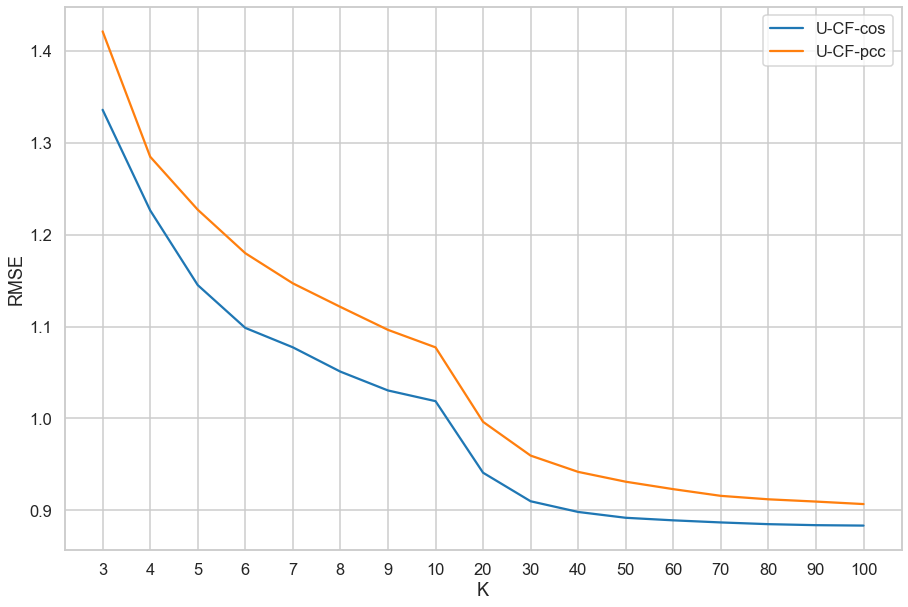

In [85]:
# 將K轉成字串形式
str_k = list(map(lambda x:str(x), K))
# numpy to pandas
df = pd.DataFrame({"K": str_k, "U-CF-cos":ucf_cos, "U-CF-pcc":ucf_pcc})
# Visualize
plot_result(df)

## 1.2. Item-based Collaborative Filtering (I-CF)

In [87]:
# Transpose user_matrix as movie_matrix, bias_matrix as movie_bias.
movie_matrix = user_matrix.T
movie_bias = bias_matrix.T
movie_matrix.shape, movie_bias.shape

((1682, 943), (1682, 943))

In [88]:
### 電影校正後會產生zero vec故在這裡不採用校正後matrix算相似度 ###

# # 計算電影平均評分
# movie_mean = non_zero_mean(movie_matrix)
# # 使用個別電影平均校正電影對使用者的評分
# movie_adjust = np.where(movie_matrix == 0, movie_matrix, movie_matrix-movie_mean)
# print(f"movie_matrix:\n{movie_matrix} \n\nafter adjust:\n{movie_adjust}")

movie_matrix:
[[0. 4. 0. ... 5. 0. 0.]
 [3. 0. 0. ... 0. 0. 5.]
 [4. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

after adjust:
[[ 0.          0.15264798  0.         ...  1.15264798  0.
   0.        ]
 [-0.20618557  0.          0.         ...  0.          0.
   1.79381443]
 [ 0.90769231  0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


C:\Users\Baron\AppData\Local\Temp/ipykernel_17640/3977289571.py:7: RuntimeWarning: invalid value encountered in true_divide
  return np.reshape(total/exist_number, (-1, 1))


In [112]:
# 取得movie間的相似度名單
cos_mdict, pcc_mdict = get_sim_dict(movie, movie_matrix)

caculator u & v similar: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1682/1682 [04:26<00:00,  6.32it/s]


### 1.2.1.  Item‐Based CF use Cosine result

In [119]:
# 與不同K個電影相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
icf_cos = list()

# 針對不同相似電影個數進行分析
for k in K:
    predict_matrix = np.zeros((len(movie), len(user)))
    # 取出前K個相似度最大的使用者名稱，並設置於N
    for i in tqdm(cos_mdict.keys(), desc=f"predicting K = {k}"):
        # Siv: 取出前K個最相似的電影相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Siv = heapq.nlargest(k,cos_mdict[i])
        # top_sim_index: 取出前K個最相似的電影相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(cos_mdict[i].index, heapq.nlargest(k,cos_mdict[i])))
        # 利用相似的電影對電影的每一位使用者做評分預測
        for u in range(len(user)):
            # R: 相似電影對調整後使用者 u 的評分
            try:
                R = [movie_adjust[:,u][j] - movie_bias[i, j] for j in top_sim_index]
            except:
                print(f"i={i}, j={j}, u={u}")
            # 預測使用者u對於第m部電影的評分
            Riu = predict(Siv, R) + movie_bias[i, u]
            predict_matrix[i, u] = Riu
    icf_cos.append(mse(movie_adjust, predict_matrix, squared = False))

predicting K = 100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1682/1682 [01:36<00:00, 17.45it/s]


### 1.2.2.  Item‐Based CF use Pearson Correlation Coefficient result

In [120]:
# 與不同K個電影相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
icf_pcc = list()

# 針對不同相似電影個數進行分析
for k in K:
    predict_matrix = np.zeros((len(movie), len(user)))
    # 取出前K個相似度最大的使用者名稱，並設置於N
    for i in tqdm(pcc_mdict.keys(), desc=f"predicting K = {k}"):
        # Siv: 取出前K個最相似的電影相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Siv = heapq.nlargest(k,pcc_mdict[i])
        # top_sim_index: 取出前K個最相似的電影相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(pcc_mdict[i].index, heapq.nlargest(k,pcc_mdict[i])))
        # 利用相似的電影對電影的每一位使用者做評分預測
        for u in range(len(user)):
            # R: 相似電影對調整後使用者 u 的評分
            try:
                R = [movie_adjust[:,u][j] - movie_bias[i, j] for j in top_sim_index]
            except:
                print(f"i={i}, j={j}, u={u}")
            # 預測使用者u對於第m部電影的評分
            Riu = predict(Siv, R) + movie_bias[i, u]
            predict_matrix[i, u] = Riu
    icf_pcc.append(mse(movie_adjust, predict_matrix, squared = False))

predicting K = 100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1682/1682 [01:32<00:00, 18.25it/s]


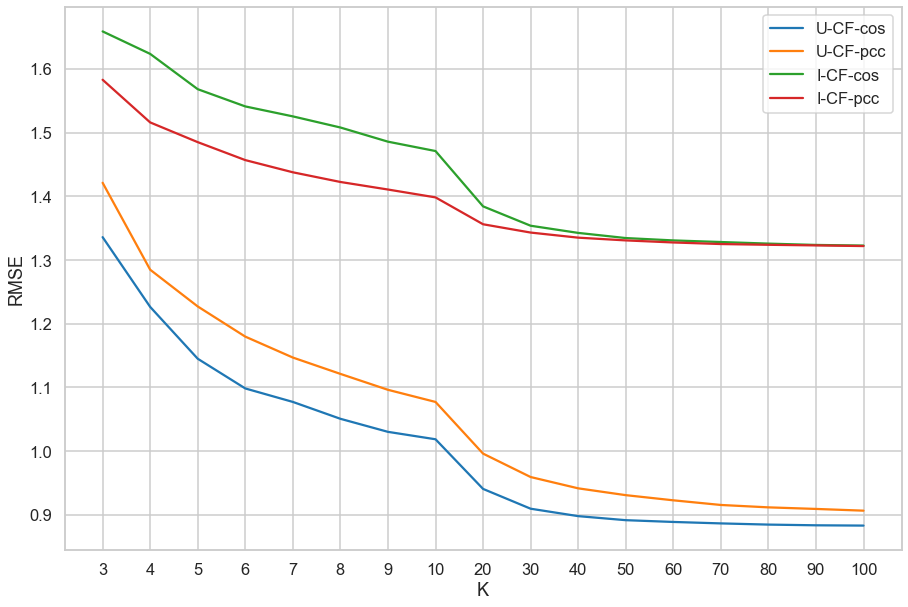

In [121]:
# numpy to pandas
df["I-CF-cos"] = icf_cos
df["I-CF-pcc"] = icf_pcc
# Visualize
plot_result(df)